# Handed Coded Logistic Regression and Neural Network

#### Part of the code is borrowed from http://cs231n.github.io/neural-networks-case-study/ and http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/, based on which I have made some modifications for ease of use and extra functionalities

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline

##  Generate a dataset with binary classes

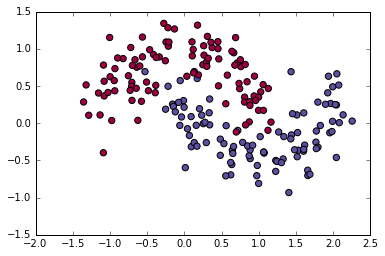

In [3]:
np.random.seed(0)
data, label = sklearn.datasets.make_moons(200, noise=0.20) # create 2-dimentional data belong to two categories, in size (200,2)
plt.scatter(data[:,0], data[:,1], s=40, c=label, cmap=plt.cm.Spectral)

In [8]:
def plot_decision_boundary(model,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## Logistic Regression - Scikit Learn

In [56]:
logistic = sklearn.linear_model.LogisticRegressionCV()
logistic.fit(data, label)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

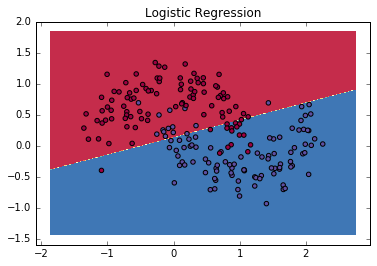

In [103]:
# Plot the decision boundary
plot_decision_boundary(logistic,data,label)
plt.title("Logistic Regression")

## Logistic Regression - Handed coded

In [4]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

In [365]:
class Logistic_hand(object):
    def __init__(self, data, label):
        self.data = data
        self.label = label

        self.data_num, n = data.shape
        self.weights = np.ones(n)
        self.b = 1 # beta0/weight for the intercept

    # stochastic gradient descent
    def train(self, num_iteration,alpha,reg_lambda,batch_size):
        '''
            num_iteration: number of iterations for stochastic gradient descent
            alpha: learning rate
            reg_lambda: regularization factor, the higher the smaller the weights, the simpler the model
            batch_size: number of data instances to sample from each iteration, to calculate gradient. 
                        The larger the more precise for weights, the slower it will take
        '''
        for j in xrange(num_iteration):
            data_index = range(self.data_num) # indices of all data rows
            for i in xrange(batch_size): # in each iteration, randomly select n (batch_size) rows to do gradient descent
                rand_index = int(np.random.uniform(0, len(data_index))) # randomly select a row index of data
                error = self.label[rand_index] - sigmoid(sum(self.data[rand_index] * self.weights + self.b)) # cost function
                '''gradient descent w/o regularization'''
                #self.weights += alpha * error * self.data[rand_index] # batch update for all weights, gradient=error*self.data[rand_index]
                '''gradient descent w/ regularization'''
                self.weights = self.weights*(1-alpha*reg_lambda) + alpha * error * self.data[rand_index] # batch update for all weights, gradient=error*self.data[rand_index]
                self.b += alpha * error # update beta0 
                del(data_index[rand_index]) # delete this row index so it won't be selected again

    # return predicted class label
    def predict(self, predict_data):
        result = map(lambda x: 1 if sum(self.weights * x + self.b) > 0 else 0,predict_data)
        return np.array(result)
    
    # return predicted probability
    def predict_prob(self, predict_data):
        result = map(lambda x: sigmoid(sum(self.weights * x + self.b)),predict_data)
        return np.array(result)

### Train the logistic model

time spent:  0.747846126556


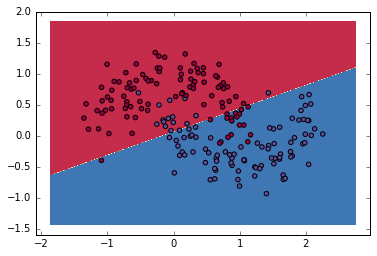

In [377]:
if __name__ == '__main__':
    start = time.time()
    logistic_hand = Logistic_hand(data, label)
    logistic_hand.train(num_iteration=100,alpha=0.1,reg_lambda=0.01,batch_size=50)
    plot_decision_boundary(logistic_hand, data, label)
    print "time spent: ",time.time()-start

### Make predictions

In [244]:
print 'category predictions for the first five rows: ',logistic_hand.predict(data[:5,])
print 'probability predictions for the first five rows: ',logistic_hand.predict_prob(data[:5,])

category predictions for the first five rows:  [0 1 0 1 1]
probability predictions for the first five rows:  [ 0.33951036  0.99622121  0.32944178  0.788252    0.98041746]


## 3-Layer Neural Network

In [75]:
class NN(object):
    def __init__(self, data, label, num_hidden_nodes):
        self.data = data
        self.label = label
        self.num_hidden_nodes = num_hidden_nodes

        self.num_examples, self.nn_input_dim = np.shape(data)
        self.nn_output_dim = 2 # number of output nodes

        # initialize weights with small random values, which we are going to be learned during training
        np.random.seed(0)
        self.W1 = np.random.randn(self.nn_input_dim, self.num_hidden_nodes) / np.sqrt(self.nn_input_dim) # weights between layer1 and 2
        self.b1 = np.zeros((1, self.num_hidden_nodes)) # weight for intercept at layer1
        self.W2 = np.random.randn(num_hidden_nodes, self.nn_output_dim) / np.sqrt(num_hidden_nodes) # weights between layer2 and 3
        self.b2 = np.zeros((1, self.nn_output_dim)) # weight for intercept at layer2

    def batch_gradient_descent(self, num_iteration, alpha, reg_lambda, print_loss):
        for i in xrange(num_iteration):
            
            # Forward propagation
            z1 = self.data.dot(self.W1) + self.b1
            a1 = np.tanh(z1) # used tanh as the activation function
            # calculate output probabilities for all classes using softmax function
            z2 = a1.dot(self.W2) + self.b2
            # turn log probabilities of each class to unnormalized probabilities
            exp_scores = np.exp(z2) 
            # normalized predicted probabilities of all classes for each instance
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
            # We now have an array probs of size [num of examples x num of classes], where each row now contains the 
            # class probabilities. In particular, since we’ve normalized them every row now sums to one.
            
            # compute the loss: average cross-entropy loss + regularization
            if print_loss == True:
                # calculate cross-entropy loss
                # negative log of the predicted probability of the true class
                # we only compute the loss of the true class in each example
                # This is 1D array of the predicted prob of the true class for each example.
                corect_logprobs = -np.log(probs[range(self.num_examples),self.label])
                # average loss for this batch
                data_loss = np.sum(corect_logprobs)/self.num_examples 
                # L2 regularization pentalty
                # 0.5 is for the convenience of weights updates with regularization
                reg_loss = 0.5*reg_lambda*(np.sum(self.W1*self.W1) + np.sum(self.W2*self.W2)) 
                # full loss is the average of the log probabilities and the regularization loss
                loss = data_loss + reg_loss 
                if i % 50 == 0:
                    print "iteration %d: loss %f" % (i, loss)
                
            # Backpropagation
            delta3 = probs
            '''
                Explanation of the next line of code:
                Suppose the probabilities we computed were probs = [0.2, 0.3, 0.5], and the correct class was the middle one 
                (with probability 0.3). According to this derivation, the gradient on the scores would be delta3 = [0.2, -0.7, 0.5]. 
                We see that this result is highly intuitive: increasing the first or last element of the score vector probs 
                (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and +0.5), which 
                is bad. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 
                is telling us that increasing the correct class score would lead to a decrease of the loss, which makes sense.
            '''
            delta3[range(self.num_examples), self.label] -= 1 # the gradient of loss w.r.t. z2 for each instance
            delta3 /= self.num_examples
            dW2 = (a1.T).dot(delta3) # delta for W2
            db2 = np.sum(delta3, axis=0, keepdims=True) # delta for b2
            delta2 = delta3.dot(self.W2.T) * (1 - np.power(a1, 2)) # the gradient of error at the second layer, the latter part is the derivative for tanh
            dW1 = np.dot(self.data.T, delta2) # delta for W1
            db1 = np.sum(delta2, axis=0) # delta for b1

            # Add regularization terms for weights
            dW2 += reg_lambda * self.W2
            dW1 += reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -alpha * dW1
            self.b1 += -alpha * db1
            self.W2 += -alpha * dW2
            self.b2 += -alpha * db2

    def stochastic_gradient_descent(self, num_iteration, alpha, reg_lambda, batch_size):
        '''
            num_iteration: number of iterations for stochastic gradient descent
            alpha: learning rate
            reg_lambda: regularization factor, the higher the smaller the weights, the simpler the model
            batch_size: number of data instances to sample from each iteration, to calculate gradient. 
                        The larger the more precise for weights, the slower it will take. The slower the size, the more bias in the training
        '''
        for i in xrange(num_iteration):
            data_index = range(self.num_examples) # indices of all data rows
            
            # in each iteration, randomly select n (batch_size) rows to do gradient descent
            # here it loops through it example in the batch, it is slower than doing batch-level matrix operation
            for j in xrange(batch_size): 
                rand_index = int(np.random.uniform(0, len(data_index))) # randomly select a row index of data
                x = np.mat(self.data[rand_index])
                y = self.label[rand_index]
                
                # Forward propagation of single example
                z1 = x.dot(self.W1) + self.b1
                a1 = np.tanh(z1) # here I used tanh as the activation function
                z2 = a1.dot(self.W2) + self.b2
                # calculate output probabilities for all classes using softmax function
                exp_scores = np.exp(z2) # turn log probabilities of each class to unnormalized probabilities
                probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # normalized predicted probabilities of all classes for each instance
                
                
                # Backpropagation of single example
                delta3 = probs 
                if y:
                    delta3[0, 0] -= 1
                else:
                    delta3[0, 1] -= 1
                dW2 = (a1.T).dot(delta3)
                db2 = np.sum(delta3, axis=0, keepdims=True)
                va = delta3.dot(self.W2.T)
                vb = 1 - np.power(a1, 2)
                delta2 = np.mat(np.array(va) * np.array(vb))
                dW1 = x.T.dot(delta2)
                db1 = np.sum(delta2, axis=0)

                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW2 += reg_lambda * self.W2
                dW1 += reg_lambda * self.W1

                # Gradient descent parameter update
                self.W1 += -alpha * dW1
                self.b1 += -alpha * db1
                self.W2 += -alpha * dW2
                self.b2 += -alpha * db2

                del(data_index[rand_index])
                    
    # return predicted labels
    def predict(self, x):
        # Forward propagation
        z1 = x.dot(self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return np.argmax(probs, axis=1)
    
    # return predicted probabilities
    def predict_prob(self, x):
        # Forward propagation
        z1 = x.dot(self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    # print training accuracy
    def train_accuracy(self, x):
        # Forward propagation
        z1 = x.dot(self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        predicted_class = np.argmax(probs, axis=1)
        print 'training accuracy: %.2f' % (np.mean(predicted_class == self.label))

### Train the neural network

iteration 0: loss 0.623379
time spent:  0.227497816086


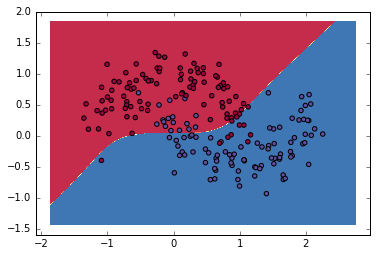

In [80]:
if __name__ == '__main__':
    start = time.time()
    nn = NN(data, label, num_hidden_nodes=3)
    nn.batch_gradient_descent(num_iteration = 50, alpha=0.01, reg_lambda=0.01, print_loss=True)
    #nn.stochastic_gradient_descent(num_iteration = 250, alpha=0.01, reg_lambda=0.01, batch_size=190)
    plot_decision_boundary(nn, data, label)
    print "time spent: ",time.time()-start

### Make predictions

In [486]:
print 'category predictions for the first five rows: ',nn.predict(data[:5,])
print 'probability predictions for the first five rows: \n',nn.predict_prob(data[:5,])
nn.train_accuracy(data)

category predictions for the first five rows:  [0 1 1 0 1]
probability predictions for the first five rows: 
[[  9.99654115e-01   3.45885335e-04]
 [  2.61898675e-04   9.99738101e-01]
 [  3.03122841e-02   9.69687716e-01]
 [  9.88577268e-01   1.14227317e-02]
 [  9.34912113e-04   9.99065088e-01]]
training accuracy: 0.97
